In [1]:
"""
This is based off of Katrin's code (from doi:10.1016/S1540-7489(02)80127-4)

This example is from doi:10.1007/BF00807201 where:
- gauze has 1024 meshes/cm2
- temperature varied from 200-900C
- gauze located at 19? mm, 15 mm diameter
- diameter of 15 mm
- atmospheric pressure
- spacetime ranged from 0.00021-.00042s
- The space time is calculated by:
    open area of gauze (15mm) * wire diameter (60 um) and the gas flow rate
- feed composition:
    CH4:O2:Ar ~ 2:1:10
-contact times .21-.42 ms

"""
# this chemkin file is from the cti generated by rmg

# load a bunch of stuff
from __future__ import division
# load
import cantera as ct
import numpy as np
import scipy
import pylab
import matplotlib
import matplotlib.pyplot  as plt
import matplotlib.gridspec as gridspec
from matplotlib.ticker import NullFormatter, MaxNLocator, LogLocator
import csv
from pydas.dassl import DASSL
import os
import rmgpy
import rmg
import re
import operator
import pandas as pd
%matplotlib inline

gas = ct.Solution('./chem_annotated.cti','gas')
surf = ct.Interface('./chem_annotated.cti','surface1', [gas])
# cantera files without gas??
gas2 = ct.Solution('./chem_annotated.cti','gas')
gas2.set_multiplier(0.0)
surf2 = ct.Interface('./chem_annotated.cti','surface1', [gas2])

gas3 = ct.Solution('./chem_annotated.cti','gas')
surf3 = ct.Interface('./chem_annotated.cti','surface1', [gas3])

print "This mechanism contains %d gas reactions and %d surface reactions"%(gas.n_reactions, surf.n_reactions)
i_n2 = gas.species_index('N2')
i_ch4 = gas.species_index('CH4(2)')
i_o2 = gas.species_index('O2(3)')
i_co2 = gas.species_index('CO2(4)')
i_h2o = gas.species_index('H2O(5)')
i_h2 = gas.species_index('H2(6)')
i_co = gas.species_index('CO(7)')

# unit conversion factors to SI
mm = 0.001
ms = mm
minute = 60.0

#######################################################################
# Input Parameters
#######################################################################
t_in = 1073.15 #K
t_cat = 1073.15 #K
length = 40 * mm  # Reactor length - gauze at 19mm from the start
diam = 15*mm # Reactor diameter
area = (diam/2.0)**2*np.pi  # Reactor cross section area (area of tube)

mesh = 1024. # mesh size in meshes/cm2
wire = 0.00006 # wire thickness in m

mesh = mesh/(0.01**2) # convert to mesh/m2
holes = np.sqrt(mesh)*diam # number of holes across the diameter
gas_area = ((diam/holes)-wire)**2 # gas area in one hole, meter2
mesh_area = (diam/holes)**2 # total area in one hole, meter2
open_area = gas_area/mesh_area*area # total open gas area in gauze
cat_area = (1-gas_area/mesh_area)*area # total cat surface area in gauze, m2

cat_area_per_vol = cat_area/(open_area*wire)  # Catalyst particle surface area per unit volume in m^-1
contact_time = 0.21 * ms # time in contact with gauze, in seconds
velocity = wire/contact_time  # gas velocity going through gauze, m/s
porosity = 1.  # Monolith channel porosity

print velocity
# The PFR will be simulated by a chain of 'NReactors' stirred reactors.
NReactors = 4001

cat_on = 1900
cat_off = 1910
dt = 1.0

Using Theano backend.
/scratch/westgroup/mazeau/Cat/RMG-Py/rmgpy/tools/plot.py:34: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/home/mazeau.e/anaconda2/envs/rmg_env3/lib/python2.7/runpy.py", line 174, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/home/mazeau.e/anaconda2/envs/rmg_env3/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/home/mazeau.e/anaconda2/envs/rmg_env3/lib/python2.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/mazeau.e/anaconda2/envs/rmg_env3/lib/python2.7/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/maz

This mechanism contains 41 gas reactions and 40 surface reactions
0.285714285714


In [2]:
# import the gas model and set the initial conditions
gas.TPX = t_in, ct.one_atm, 'CH4(2):0.2, O2(3):0.1, N2:1' 
gas2.TPX = t_in, ct.one_atm, 'CH4(2):0.2, O2(3):0.1, N2:1' 

# import the surface model
surf.TP = t_cat, ct.one_atm
surf2.TP = t_cat, ct.one_atm
surf.coverages = 'X(1):1.0'
surf2.coverages = 'X(1):1.0'

reactor_len = length/(NReactors-1)
rvol = area * reactor_len * porosity

# catalyst area in one reactor
cat_area = cat_area_per_vol * rvol

mass_flow_rate = velocity * gas.density * area

# The plug flow reactor is represented by a linear chain of zero-dimensional
# reactors. The gas at the inlet to the first one has the specified inlet
# composition, and for all others the inlet composition is fixed at the
# composition of the reactor immediately upstream. Since in a PFR model there
# is no diffusion, the upstream reactors are not affected by any downstream
# reactors, and therefore the problem may be solved by simply marching from
# the first to last reactor, integrating each one to steady state.

TDY = gas.TDY
cov = surf.coverages

In [3]:
print('    distance       X_CH4        X_O2        X_H2       X_CO       X_H2O       X_CO2')

# create a new reactor
gas.TDY = TDY
r = ct.IdealGasReactor(gas)
r.volume = rvol

# create a reservoir to represent the reactor immediately upstream. Note
# that the gas object is set already to the state of the upstream reactor
upstream = ct.Reservoir(gas, name='upstream')

# create a reservoir for the reactor to exhaust into. The composition of
# this reservoir is irrelevant.
downstream = ct.Reservoir(gas, name='downstream')

# Add the reacting surface to the reactor. The area is set to the desired
# catalyst area in the reactor.
rsurf = ct.ReactorSurface(surf, r, A=cat_area)

# The mass flow rate into the reactor will be fixed by using a
# MassFlowController object.
m = ct.MassFlowController(upstream, r, mdot=mass_flow_rate)

# We need an outlet to the downstream reservoir. This will determine the
# pressure in the reactor. The value of K will only affect the transient
# pressure difference.
v = ct.PressureController(r, downstream, master=m, K=1e-5)

sim = ct.ReactorNet([r])
sim.max_err_test_fails = 12

# set relative and absolute tolerances on the simulation
sim.rtol = 1.0e-10
sim.atol = 1.0e-20

gas_names = gas.species_names
surf_names = surf.species_names
gas_out = []
surf_out = []
dist_array=[]
T_array = []


surf.set_multiplier(0.0) #no surface reactions until the gauze
for n in range(NReactors):
    # Set the state of the reservoir to match that of the previous reactor
    gas.TDY = r.thermo.TDY
    upstream.syncState()
    if n==cat_on:
        surf.set_multiplier(1.0)
    if n==cat_off:
        surf.set_multiplier(0.0)
    sim.reinitialize()
    sim.advance_to_steady_state()
    dist = n * reactor_len * 1.0e3   # distance in mm
    dist_array.append(dist)
    T_array.append(surf.T)
    gas_out.append(gas.X.copy())
    surf_out.append(surf.X.copy())
    
    if not n % 100:
        print('  {0:10f}  {1:10f}  {2:10f}  {3:10f} {4:10f} {5:10f} {6:10f}'.format(dist, *gas['CH4(2)','O2(3)','H2(6)','CO(7)','H2O(5)','CO2(4)'].X))
        #print(surf.T)
        #print(gas.P)
        #print(surf.coverages)

gas_out = np.array(gas_out)
surf_out = np.array(surf_out)
gas_names = np.array(gas_names)
surf_names = np.array(surf_names)

    distance       X_CH4        X_O2        X_H2       X_CO       X_H2O       X_CO2
    0.000000    0.153846    0.076923    0.000000   0.000000   0.000000   0.000000
    1.000000    0.153846    0.076923    0.000000   0.000000   0.000000   0.000000
    2.000000    0.153846    0.076923    0.000000   0.000000   0.000000   0.000000
    3.000000    0.153846    0.076923    0.000000   0.000000   0.000000   0.000000
    4.000000    0.153846    0.076923    0.000000   0.000000   0.000000   0.000000
    5.000000    0.153846    0.076923    0.000000   0.000000   0.000000   0.000000
    6.000000    0.153846    0.076923    0.000000   0.000000   0.000000   0.000000
    7.000000    0.153846    0.076923    0.000000   0.000000   0.000000   0.000000
    8.000000    0.153846    0.076923    0.000000   0.000000   0.000000   0.000000
    9.000000    0.153846    0.076923    0.000000   0.000000   0.000000   0.000000
   10.000000    0.153846    0.076923    0.000000   0.000000   0.000000   0.000000
   11.000000  

In [4]:
print('    distance       X_CH4        X_O2        X_H2       X_CO       X_H2O       X_CO2')
# create a new reactor for when gas phase reactions are not included
gas2.TDY = TDY
r2 = ct.IdealGasReactor(gas2)
r2.volume = rvol

# create a reservoir to represent the reactor immediately upstream. Note
# that the gas object is set already to the state of the upstream reactor
upstream2 = ct.Reservoir(gas2, name='upstream')

# create a reservoir for the reactor to exhaust into. The composition of
# this reservoir is irrelevant.
downstream2 = ct.Reservoir(gas2, name='downstream')

# Add the reacting surface to the reactor. The area is set to the desired
# catalyst area in the reactor.
rsurf2 = ct.ReactorSurface(surf2, r2, A=cat_area)

# The mass flow rate into the reactor will be fixed by using a
# MassFlowController object.
m2 = ct.MassFlowController(upstream2, r2, mdot=mass_flow_rate)

# We need an outlet to the downstream reservoir. This will determine the
# pressure in the reactor. The value of K will only affect the transient
# pressure difference.
v2 = ct.PressureController(r2, downstream2, master=m2, K=1e-5)

sim2 = ct.ReactorNet([r2])
sim2.max_err_test_fails = 12

# set relative and absolute tolerances on the simulation
sim2.rtol = 1.0e-10
sim2.atol = 1.0e-20

gas2_names = gas2.species_names
surf2_names = surf2.species_names
gas2_out = []
surf2_out = []
dist2_array=[]
T2_array = []
surf2.set_multiplier(0.0) #no surface reactions until in the middle of the reactor.
for n in range(NReactors):
    # Set the state of the reservoir to match that of the previous reactor
    gas2.TDY = r2.thermo.TDY
    upstream2.syncState()
    if n==cat_on:
        surf2.set_multiplier(1.0)
        print(surf2.T)
    if n==cat_off:
        surf2.set_multiplier(0.0)
        print(surf2.T)
    sim2.reinitialize()
    sim2.advance_to_steady_state()
    dist2 = n * reactor_len * 1.0e3   # distance in mm
    dist2_array.append(dist2)
    T2_array.append(surf2.T)
    gas2_out.append(gas2.X.copy())
    surf2_out.append(surf2.X.copy())

    if not n % 100:
        print('  {0:10f}  {1:10f}  {2:10f}  {3:10f} {4:10f} {5:10f} {6:10f}'.format(dist2, *gas2['CH4(2)','O2(3)','H2(6)','CO(7)','H2O(5)','CO2(4)'].X))
        #print(surf2.T)

gas2_out = np.array(gas2_out)
surf2_out = np.array(surf2_out)
gas2_names = np.array(gas2_names)
surf2_names = np.array(surf2_names)

    distance       X_CH4        X_O2        X_H2       X_CO       X_H2O       X_CO2
    0.000000    0.153846    0.076923    0.000000   0.000000   0.000000   0.000000
    1.000000    0.153846    0.076923    0.000000   0.000000   0.000000   0.000000
    2.000000    0.153846    0.076923    0.000000   0.000000   0.000000   0.000000
    3.000000    0.153846    0.076923    0.000000   0.000000   0.000000   0.000000
    4.000000    0.153846    0.076923    0.000000   0.000000   0.000000   0.000000
    5.000000    0.153846    0.076923    0.000000   0.000000   0.000000   0.000000
    6.000000    0.153846    0.076923    0.000000   0.000000   0.000000   0.000000
    7.000000    0.153846    0.076923    0.000000   0.000000   0.000000   0.000000
    8.000000    0.153846    0.076923    0.000000   0.000000   0.000000   0.000000
    9.000000    0.153846    0.076923    0.000000   0.000000   0.000000   0.000000
   10.000000    0.153846    0.076923    0.000000   0.000000   0.000000   0.000000
   11.000000  

N2
CH4(2)
O2(3)
CO2(4)
H2O(5)
H2(6)
CO(7)
C2H4(18)


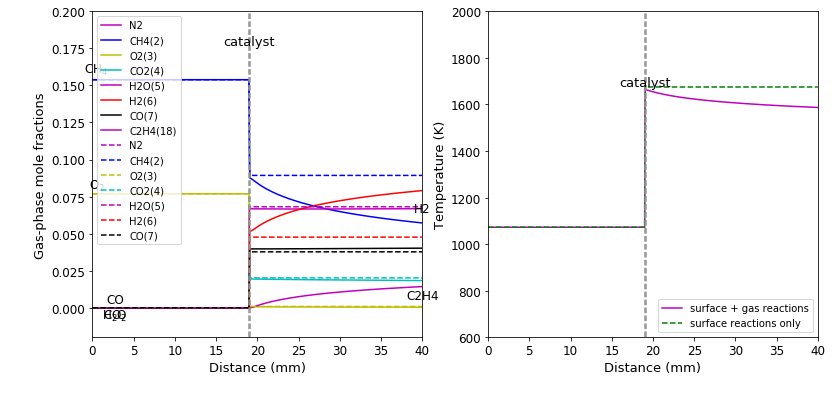

In [5]:
import pylab
import matplotlib
import matplotlib.pyplot  as plt
import matplotlib.gridspec as gridspec
from matplotlib.pyplot import cm
from cycler import cycler
%matplotlib inline
# configure the plot
fig, axs = plt.subplots(1,2)


axs[0].set_prop_cycle(cycler('color', ['m', 'g', 'b', 'y', 'c', 'm', 'r', 'k','g']))                          

#PLOT WITH GAS PHASE REACTIONS INCLUDED
for i in range(len(gas_out[0,:])):
    if gas_out[:,i].max() > 5.e-3:
        print(gas_names[i])
        axs[0].plot(dist_array, gas_out[:,i], label=gas_names[i])
        species_name = gas_names[i]
        if species_name.endswith(')'):
                        if species_name[-3] == '(':
                            species_name = species_name[0:-3]
                        else:
                            species_name = species_name[0:-4]
        if species_name == "O2":
            axs[0].annotate("O$_2$", fontsize=12, xy=(dist_array[50], gas_out[:,i][10]+gas_out[:,i][10]/100.0), va =('bottom'), ha = ('center'))
        elif species_name == "CO2":
            axs[0].annotate("CO$_2$", fontsize=12, xy=(dist_array[275], gas_out[:,i][275]-gas_out[:,i][275]/10.0), va =('top'), ha = ('center'))
        elif species_name == "CO":
            axs[0].annotate("CO", fontsize=12, xy=(dist_array[275], gas_out[:,i][275]+0.001), va =('bottom'), ha = ('center'))
        elif species_name == "CH2O":
            axs[0].annotate("CH$_2$O", fontsize=12, xy=(dist_array[50], gas_out[:,i][50]+0.001), va =('bottom'), ha = ('center'))    
        elif species_name == "CH4":
            axs[0].annotate("CH$_4$", fontsize=12, xy=(dist_array[50], gas_out[:,i][50]+gas_out[:,i][50]/100.0), va =('bottom'), ha = ('center'))  
        elif species_name == "H2O":
            axs[0].annotate("H$_2$O", fontsize=12, xy=(dist_array[275], gas_out[:,i][275]-gas_out[:,i][275]/40.0), va =('top'), ha = ('center'))   
        else:                     
            axs[0].annotate(species_name, fontsize=12, xy=(dist_array[-1], gas_out[:,i][-1]-gas_out[:,i][-1]/10.0), va =('top'), ha = ('center'))
    else:
        axs[0].plot(0,0)
        
axs[1].set_prop_cycle(cycler('color', ['m', 'g', 'b', 'y', 'c', 'm', 'r', 'k','g']))  
#Plot two temperatures (of gas-phase and surface vs only surface.)
axs[1].plot(dist_array, T_array, label="surface + gas reactions")
axs[1].plot(dist_array, T2_array, "--", label="surface reactions only")


axs[0].set_prop_cycle(cycler('color', ['m', 'g', 'b', 'y', 'c', 'm', 'r', 'k','g']))
#PLOT WITHOUT GAS PHASE REACTIONS
for i in range(len(gas2_out[0,:])):
    if gas2_out[:,i].max() > 1.e-3:
        axs[0].plot(dist2_array, gas2_out[:,i], '--', label=gas2_names[i])
    else:
        axs[0].plot(0,0)  
axs[1].set_prop_cycle(cycler('color', ['m', 'g', 'b', 'y', 'c', 'm', 'r', 'k','g']))    


axs[0].plot([dist_array[cat_on], dist_array[cat_on]],[-0.02,0.2], linestyle='--', color='xkcd:grey')
axs[0].plot([dist_array[cat_off], dist_array[cat_off]],[-0.02,0.2], linestyle='--', color='xkcd:grey')  
axs[0].annotate("catalyst", fontsize=13, xy=(dist_array[cat_on], 0.175), va =('bottom'), ha = ('center'))
axs[1].plot([dist_array[cat_on], dist_array[cat_on]],[600.0,2000], linestyle='--', color='xkcd:grey')
axs[1].plot([dist_array[cat_off], dist_array[cat_off]],[600.0,2000], linestyle='--', color='xkcd:grey')
axs[1].annotate("catalyst", fontsize=13, xy=(dist_array[cat_on], 1665), va =('bottom'), ha = ('center'))
        
for item in (axs[0].get_xticklabels() + axs[0].get_yticklabels() + axs[1].get_xticklabels() + axs[1].get_yticklabels()):
    item.set_fontsize(12)

axs[1].legend(loc="lower right")
axs[0].legend(loc="upper left")
axs[0].set_ylim(-0.02,0.2); axs[1].set_ylim(600.0,2000)
axs[0].set_xlim(0.0,length/mm); axs[1].set_xlim(0.0,length/mm)
axs[0].set_xlabel('Distance (mm)', fontsize=13); axs[1].set_xlabel('Distance (mm)', fontsize=13); #axs[0,1].set_xlabel('time (s)'); axs[1,1].set_xlabel('time (s)')
axs[0].set_ylabel('Gas-phase mole fractions', fontsize=13); axs[1].set_ylabel('Temperature (K)', fontsize=13)
#fig.tight_layout()
#axs[1,0].ticklabel_format(axis='x', style='sci', scilimits=(0,0))
#axs[0,1].ticklabel_format(axis='x', style='sci', scilimits=(0,0))
#axs[1,1].ticklabel_format(axis='x', style='sci', scilimits=(0,0))
fig.set_figheight(6)
fig.set_figwidth(13)
fig.savefig('T1073K.png')
#axs[0].grid(); axs[1].grid(); #axs[1,0].grid(); axs[1,1].grid()

N2
CH4(2)
O2(3)
CO2(4)
H2O(5)
H2(6)
CO(7)
C2H4(18)


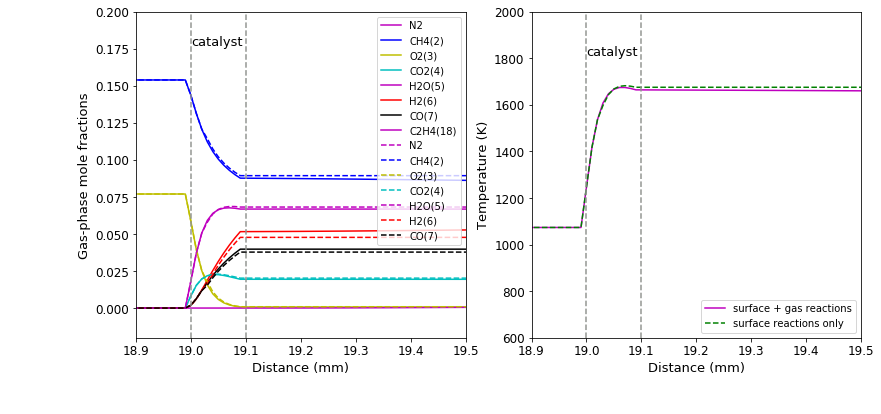

In [6]:
import pylab
import matplotlib
import matplotlib.pyplot  as plt
import matplotlib.gridspec as gridspec
from matplotlib.pyplot import cm
from cycler import cycler
%matplotlib inline
# configure the plot
fig, axs = plt.subplots(1,2)


axs[0].set_prop_cycle(cycler('color', ['m', 'g', 'b', 'y', 'c', 'm', 'r', 'k','g']))                          

#PLOT WITH GAS PHASE REACTIONS INCLUDED
for i in range(len(gas_out[0,:])):
    if gas_out[:,i].max() > 5.e-3:
        print(gas_names[i])
        axs[0].plot(dist_array, gas_out[:,i], label=gas_names[i])
        species_name = gas_names[i]
        if species_name.endswith(')'):
                        if species_name[-3] == '(':
                            species_name = species_name[0:-3]
                        else:
                            species_name = species_name[0:-4]
        if species_name == "O2":
            axs[0].annotate("O$_2$", fontsize=12, xy=(dist_array[50], gas_out[:,i][10]+gas_out[:,i][10]/100.0), va =('bottom'), ha = ('center'))
        elif species_name == "CO2":
            axs[0].annotate("CO$_2$", fontsize=12, xy=(dist_array[275], gas_out[:,i][275]-gas_out[:,i][275]/10.0), va =('top'), ha = ('center'))
        elif species_name == "CO":
            axs[0].annotate("CO", fontsize=12, xy=(dist_array[275], gas_out[:,i][275]+0.001), va =('bottom'), ha = ('center'))
        elif species_name == "CH2O":
            axs[0].annotate("CH$_2$O", fontsize=12, xy=(dist_array[50], gas_out[:,i][50]+0.001), va =('bottom'), ha = ('center'))    
        elif species_name == "CH4":
            axs[0].annotate("CH$_4$", fontsize=12, xy=(dist_array[50], gas_out[:,i][50]+gas_out[:,i][50]/100.0), va =('bottom'), ha = ('center'))  
        elif species_name == "H2O":
            axs[0].annotate("H$_2$O", fontsize=12, xy=(dist_array[275], gas_out[:,i][275]-gas_out[:,i][275]/40.0), va =('top'), ha = ('center'))   
        else:                     
            axs[0].annotate(species_name, fontsize=12, xy=(dist_array[-1], gas_out[:,i][-1]-gas_out[:,i][-1]/10.0), va =('top'), ha = ('center'))
    else:
        axs[0].plot(0,0)
        
axs[1].set_prop_cycle(cycler('color', ['m', 'g', 'b', 'y', 'c', 'm', 'r', 'k','g']))  
#Plot two temperatures (of gas-phase and surface vs only surface.)
axs[1].plot(dist_array, T_array, label="surface + gas reactions")
axs[1].plot(dist_array, T2_array, "--", label="surface reactions only")


axs[0].set_prop_cycle(cycler('color', ['m', 'g', 'b', 'y', 'c', 'm', 'r', 'k','g']))
#PLOT WITHOUT GAS PHASE REACTIONS
for i in range(len(gas2_out[0,:])):
    if gas2_out[:,i].max() > 1.e-3:
        axs[0].plot(dist2_array, gas2_out[:,i], '--', label=gas2_names[i])
    else:
        axs[0].plot(0,0)  
axs[1].set_prop_cycle(cycler('color', ['m', 'g', 'b', 'y', 'c', 'm', 'r', 'k','g']))    


axs[0].plot([dist_array[cat_on], dist_array[cat_on]],[-0.02,0.2], linestyle='--', color='xkcd:grey')
axs[0].plot([dist_array[cat_off], dist_array[cat_off]],[-0.02,0.2], linestyle='--', color='xkcd:grey')  
axs[0].annotate("catalyst", fontsize=13, xy=(dist_array[cat_on], 0.175), va =('bottom'), ha = ('left'))
axs[1].plot([dist_array[cat_on], dist_array[cat_on]],[600.0,2000], linestyle='--', color='xkcd:grey')
axs[1].plot([dist_array[cat_off], dist_array[cat_off]],[600.0,2000], linestyle='--', color='xkcd:grey')
axs[1].annotate("catalyst", fontsize=13, xy=(dist_array[cat_on], 1800), va =('bottom'), ha = ('left'))
        
for item in (axs[0].get_xticklabels() + axs[0].get_yticklabels() + axs[1].get_xticklabels() + axs[1].get_yticklabels()):
    item.set_fontsize(12)

axs[1].legend(loc="lower right")
axs[0].legend(loc="upper right")
axs[0].set_ylim(-0.02,0.2); axs[1].set_ylim(600.0,2000)
axs[0].set_xlim(18.9,19.5); axs[1].set_xlim(18.9,19.5)
axs[0].set_xlabel('Distance (mm)', fontsize=13); axs[1].set_xlabel('Distance (mm)', fontsize=13); #axs[0,1].set_xlabel('time (s)'); axs[1,1].set_xlabel('time (s)')
axs[0].set_ylabel('Gas-phase mole fractions', fontsize=13); axs[1].set_ylabel('Temperature (K)', fontsize=13)
#fig.tight_layout()
#axs[1,0].ticklabel_format(axis='x', style='sci', scilimits=(0,0))
#axs[0,1].ticklabel_format(axis='x', style='sci', scilimits=(0,0))
#axs[1,1].ticklabel_format(axis='x', style='sci', scilimits=(0,0))
fig.set_figheight(6)
fig.set_figwidth(13)
fig.savefig('T1073Kzoom.png')
#axs[0].grid(); axs[1].grid(); #axs[1,0].grid(); axs[1,1].grid()

# Batch reactor

      Time           CH4         O2          N2
  1.000000e-11    0.153846    0.076923    0.769231
  4.466836e-11    0.153845    0.076923    0.769232
  1.995262e-10    0.153839    0.076923    0.769237
  8.912509e-10    0.153817    0.076923    0.769260
  3.981072e-09    0.153730    0.076922    0.769348
  1.778279e-08    0.153517    0.076901    0.769582
  7.943282e-08    0.153431    0.076737    0.769833
  3.548134e-07    0.153567    0.076024    0.770390
  1.584893e-06    0.153881    0.073777    0.772037
  7.079458e-06    0.153588    0.069567    0.774174
  3.162278e-05    0.150149    0.061560    0.774767
  1.412538e-04    0.134516    0.032482    0.773658
  6.309573e-04    0.107290    0.000017    0.765095
  2.818383e-03    0.099146    0.000000    0.757603
  1.258925e-02    0.090254    0.000000    0.747789
  5.623413e-02    0.079010    0.000000    0.734556
  2.511886e-01    0.065323    0.000000    0.717914
  1.122018e+00    0.049710    0.000000    0.698597
  5.011872e+00    0.033340    0.00

Text(0.5,0,'Time(s)')

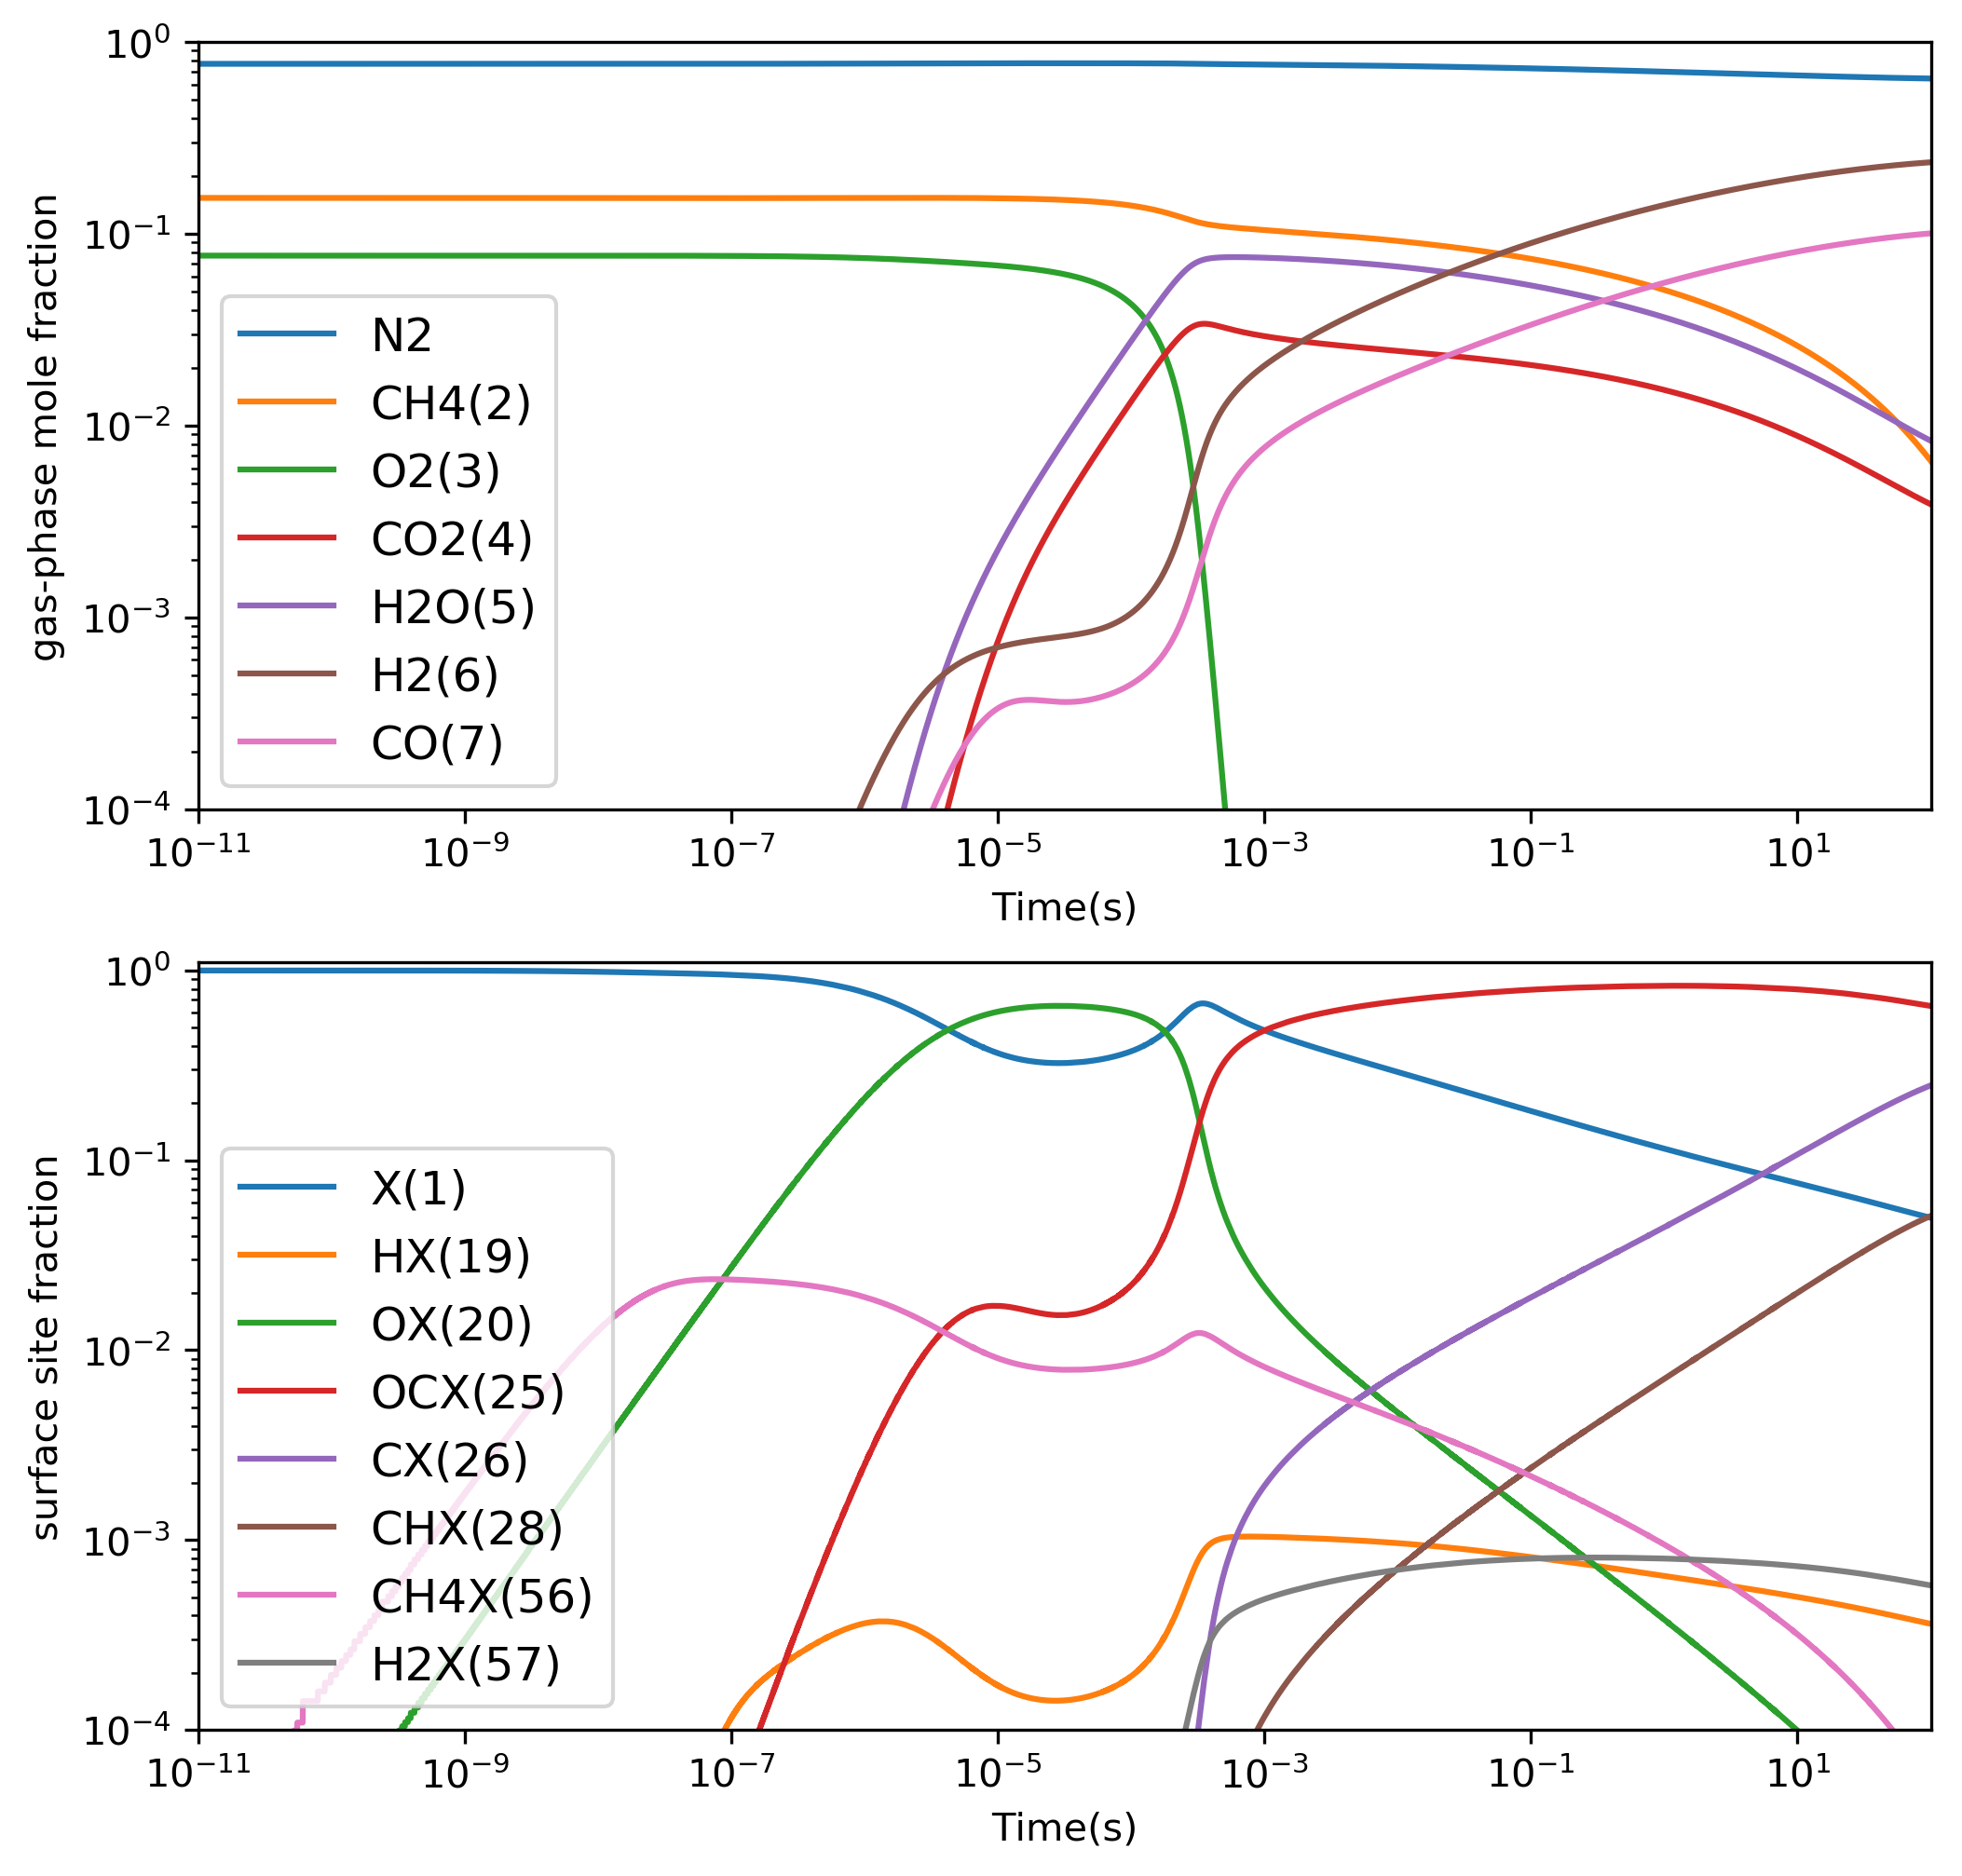

In [7]:
#######################################################################
# Input Parameters
#######################################################################
gas3.TPX = t_in, ct.one_atm, 'CH4(2):0.2, O2(3):0.1, N2:1' 
surf3.TP = t_cat, ct.one_atm
surf3.coverages = {'X(1)':1.0}

r = ct.IdealGasConstPressureReactor(gas3, energy='off')
r.volume = rvol
rsurf = ct.ReactorSurface(surf3, r, A=cat_area) # A=cat_area

sim = ct.ReactorNet([r])
sim.max_err_test_fails = 12

# set relative and absolute tolerances on the simulation
sim.rtol = 1.0e-12
sim.atol = 1.0e-20

#rxn_time = np.linspace(1e-11, 1e3, 100001) #
rxn_time = np.logspace(-11, 2, 10001) #from 0s to 1000s, log spacing

gas_mole_fracs = np.zeros([gas3.n_species, len(rxn_time)])
surf_site_fracs = np.zeros([surf3.n_species, len(rxn_time)])
temperature = np.zeros(len(rxn_time))    
pressure = np.zeros(len(rxn_time))   

print('      Time           CH4         O2          N2')

for i in range(len(rxn_time)):
    time = rxn_time[i] #define time in the reactor
    sim.advance(time) #Advance the simulation to next set time
    temperature[i] = gas3.T
    pressure[i] = gas3.P/ct.one_atm
    gas_mole_fracs[:,i] = gas3.X #
    surf_site_fracs[:,i] = surf3.coverages #
    if not i % 500:
        print('  {0:10e}  {1:10f}  {2:10f}  {3:10f}'.format(time, *gas3['CH4(2)','O2(3)','N2'].X))



#sim.advance_to_steady_state()
#print('  {0:10e}  {1:10f}  {2:10f}  {3:10f}'.format(sim.time, *gas['CH4','H2','CO'].X))    
    
# CH4_ref = gas_mole_fracs[i_ch4,:]

# setting new sensitivity to be based on time to consume 95% of the o2
O2_0 = gas_mole_fracs[i_o2,0]
zipped = zip(gas_mole_fracs[i_o2,:],rxn_time)
zipped = [list(z) for z in zipped]
for z in zipped:
    if z[0] <= O2_0 * .05:
        O2_ref_time = z[1]
        break

#Plot out simulations results
fig = pylab.figure(dpi=300,figsize=(8,8))
gs = gridspec.GridSpec(2, 1)
ax0 = plt.subplot(gs[0])
ax1 = plt.subplot(gs[1])

y_min = 1E-4

for i in range(gas.n_species):
#     if i != i_n2:
    if np.max(gas_mole_fracs[i,:]) > y_min:
        ax0.loglog(rxn_time, gas_mole_fracs[i,:], label=gas3.species_name(i) )

for i in range(surf.n_species):
    if np.max(surf_site_fracs[i,:]) > y_min:
        ax1.loglog(rxn_time, surf_site_fracs[i,:], label=surf3.species_name(i) )
            
ax0.legend(loc='lower left', fontsize = 12)
ax1.legend(loc='lower left', fontsize = 12)

ax0.set_ylabel("gas-phase mole fraction")
ax0.set_ylim(y_min,1)
ax0.set_xlim(1.0E-11,max(rxn_time))
ax1.set_xlim(1.0E-11,max(rxn_time))
ax0.set_xlabel("Time(s)")
ax1.set_ylabel("surface site fraction")
#ax0.xaxis.set_major_locator(MaxNLocator(6))
#ax0.yaxis.set_major_locator(LogLocator(base=10.0, numticks=3))
#ax0.tick_params(axis='both', which='major', labelsize=10)
ax1.set_ylim(y_min, 1.1 )
ax1.set_xlabel("Time(s)")


#######################
##   FLUX DIAGRAMS   ##
#######################
# steps = len(temperature)
# for i in range(0, steps, steps//20):
#     gas.TP = temperature[i], pressure[i] * ct.one_atm
#     gas.X  = gas_mole_fracs[:,i]
#     surf.TP = temperature[i], pressure[i] * ct.one_atm
#     surf.coverages = surf_site_fracs[:,i]
    
#     element = 'O'

#     diagram = ct.ReactionPathDiagram(surf, element)
#     diagram.title = 'Reaction path diagram following {0}'.format(element)
#     diagram.label_threshold = 0.000001

#     dot_file = 'rxnpathO{:06d}.dot'.format(i)
#     img_file = 'rxnpathO{:06d}.png'.format(i)
#     img_path = os.path.join(os.getcwd(), img_file)

#     diagram.write_dot(dot_file)
# #     print(diagram.get_data())

#     print("Wrote graphviz input file to '{0}'.".format(os.path.join(os.getcwd(), dot_file)))

#     os.system('dot {0} -Tpng -o{1} -Gdpi=200'.format(dot_file, img_file))
#     print("Wrote graphviz output file to '{0}'.".format(img_path))

#     from IPython.display import Image
#     Image(filename=img_file) 
    
# for i in range(0, steps, steps//20):
#     gas.TP = temperature[i], pressure[i] * ct.one_atm
#     gas.X  = gas_mole_fracs[:,i]
#     surf.TP = temperature[i], pressure[i] * ct.one_atm
#     surf.coverages = surf_site_fracs[:,i]
    
#     element = 'C'

#     diagram = ct.ReactionPathDiagram(surf, element)
#     diagram.title = 'Reaction path diagram following {0}'.format(element)
#     diagram.label_threshold = 0.000001

#     dot_file = 'rxnpathC{:06d}.dot'.format(i)
#     img_file = 'rxnpathC{:06d}.png'.format(i)
#     img_path = os.path.join(os.getcwd(), img_file)

#     diagram.write_dot(dot_file)
# #     print(diagram.get_data())

#     print("Wrote graphviz input file to '{0}'.".format(os.path.join(os.getcwd(), dot_file)))

#     os.system('dot {0} -Tpng -o{1} -Gdpi=200'.format(dot_file, img_file))
#     print("Wrote graphviz output file to '{0}'.".format(img_path))

#     from IPython.display import Image
#     Image(filename=img_file) 


In [8]:
with open('time.txt','w') as f:
    f.write(str(O2_ref_time))
print O2_ref_time

0.000305773609569


plt.semilogy(surf.reverse_rates_of_progress,'.')

for i in surf.reverse_rates_of_progress.argsort()[:-5:-1]:
    print i, surf.reaction_equation(i)

In [9]:
# Set the value of the perturbation
dk = 1.0e-1
# create the array to hold the sensitivty at each time step
Sensitivity = np.zeros([surf3.n_reactions,len(rxn_time)])

rxns = []
sens = []

#cycle through each reaction
for m in range(surf3.n_reactions):
    surf3.set_multiplier(1.0) # reset all multipliers  
    surf3.set_multiplier(1+dk, m) # perturb reaction m
    
    gas3.TPX = t_in, ct.one_atm, 'CH4(2):0.2, O2(3):0.1, N2:1' 
    surf3.TP = t_cat, ct.one_atm
    surf3.coverages = {'X(1)':1.0}
    
    r = ct.IdealGasConstPressureReactor(gas3, energy='off')
    r.volume = rvol
    rsurf = ct.ReactorSurface(surf3, r, A=cat_area) # A=cat_area


    sim = ct.ReactorNet([r])
    sim.max_err_test_fails = 12


    # set relative and absolute tolerances on the simulation
    sim.rtol = 1.0e-12
    sim.atol = 1.0e-20
    gas_mole_fracs = np.zeros([gas3.n_species, len(rxn_time)])
    temperature = np.zeros(len(rxn_time))    
    pressure = np.zeros(len(rxn_time))   

    for i in range(len(rxn_time)):
        time = rxn_time[i] #define time in the reactor
        sim.advance(time) #Advance the simulation to next set time
        temperature[i] = gas3.T
        pressure[i] = gas3.P/ct.one_atm
        gas_mole_fracs[:,i] = gas3.X #[mol.frac,nth reactor]
#         if not i % 1000:
#             print('  {0:10e}  {1:10f}  {2:10f}  {3:10f}'.format(time, *gas3['CH4(2)','O2(3)','N2'].X))

    # here is the new output
#     CH4_new = gas_mole_fracs[i_ch4,:]

#     O2_new = gas_mole_fracs[i_o2,:]
    zipped = zip(gas_mole_fracs[i_o2,:],rxn_time)
    zipped = [list(z) for z in zipped]
    
    for z in zipped:
        if z[0] <= O2_0 * .05:
            O2_new_time = z[1]
            break

#     Sens = (CH4_new-CH4_ref)/(CH4_ref*dk)
    Sens = (O2_ref_time - O2_new_time)/(O2_ref_time*dk) # positive if it speeds up the reaction
#     max_sensitivity = max(max(Sens),-min(Sens))
#    if (1==0):
#        if (max_sensitivity>0.01):
#            print "%d %s %.2F"%( m, surf.reaction_equations()[m],  max_sensitivity)
#    else:
#     print "%d %s %.2F"%( m, surf.reaction_equations()[m],  max_sensitivity)
    print "%d %s %.3F"%( m, surf3.reaction_equations()[m],  Sens)
#     Sensitivity[m,:] = Sens
    rxns.append(surf3.reaction_equations()[m])
    sens.append(Sens)
surf.set_multiplier(1.0)

 

0 CH4(2) + X(1) <=> CH4X(56) 0.000
1 O2(3) + 2 X(1) <=> 2 OX(20) 0.149
2 C2H6(8) + 2 X(1) <=> 2 CH3X(21) 0.000
3 CH3(10) + X(1) <=> CH3X(21) 0.000
4 CH4(2) + OX(20) + X(1) <=> CH3X(21) + HOX(22) 0.665
5 CH3OH(14) + 2 X(1) <=> CH3X(21) + HOX(22) 0.000
6 OH(17) + X(1) <=> HOX(22) 0.000
7 H2(6) + 2 X(1) <=> 2 HX(19) 0.000
8 CH4(2) + 2 X(1) <=> CH3X(21) + HX(19) 0.000
9 HX(19) + OX(20) <=> HOX(22) + X(1) 0.000
10 H2O(5) + 2 X(1) <=> HOX(22) + HX(19) 0.000
11 H(12) + X(1) <=> HX(19) 0.000
12 CH2X(27) + HX(19) <=> CH3X(21) + X(1) 0.000
13 CH2X(27) + HOX(22) <=> CH3X(21) + OX(20) 0.000
14 CHX(28) + HX(19) <=> CH2X(27) + X(1) 0.000
15 CHX(28) + HOX(22) <=> CH2X(27) + OX(20) 0.000
16 2 CH2X(27) <=> CH3X(21) + CHX(28) 0.000
17 CHX(28) + X(1) <=> CX(26) + HX(19) 0.000
18 CX(26) + H2(6) <=> CH2X(27) 0.000
19 CX(26) + HOX(22) <=> CHX(28) + OX(20) 0.000
20 CH3X(21) + CX(26) <=> CH2X(27) + CHX(28) 0.000
21 CH2X(27) + CX(26) <=> 2 CHX(28) 0.000
22 CO(7) + X(1) <=> OCX(25) 0.000
23 CX(26) + OX(20) <=> 

In [10]:
#Plot out simulations results
# fig = pylab.figure(dpi=300,figsize=(8,8))
# gs = gridspec.GridSpec(1, 1)
# ax0 = plt.subplot(gs[0])


# for m in range(surf.n_reactions):
#     y_max = 0.00001
#     if (1==1):
#         if max(Sensitivity[m,:])>y_max or min(Sensitivity[m,:])<-y_max:
#             lab = surf.reaction_equations()[m]
#             ax0.semilogx(rxn_time, Sensitivity[m,:], label=lab )
#     else:
#         if max(Normed_sensitivity[m,:])>y_max or min(Normed_sensitivity[m,:])<-y_max:
#             lab = surf.reaction_equations()[m]
#             ax0.semilogx(rxn_time, Normed_sensitivity[m,:], label=lab )
        
# ax0.legend(loc='best', fontsize = 12)   
# ax0.set_xlim(rxn_time[1], rxn_time[-1] )

# ax0.set_xlabel("Time(s)")
# ax0.set_ylabel("Sensitivity Coefficient")

In [11]:
# # now integrate with respect to time
# from numpy import trapz

# # for m in range(surf.n_reactions):
# #     ans = trapz(Sensitivity[m,:], rxn_time)#/max(rxn_time)
# #     if ans>1E-4:
# #         print "%d %s %.5f"%( m, surf.reaction_equations()[m], ans )

# n = []
# rxns = []
# for m in range(surf.n_reactions):
#     n.append(trapz(Sensitivity[m,:], rxn_time))#/max(rxn_time)
#     rxns.append(surf.reaction_equations()[m])

# ans = dict(zip(rxns,n))
# sorted_ans = sorted(ans.items(), key=operator.itemgetter(1), reverse=True)

# for x in sorted_ans:
#     print '%s %.4f'%(x)

In [12]:
species_dict = rmgpy.data.kinetics.KineticsLibrary().getSpecies('species_dictionary.txt')
keys = species_dict.keys()

# get the first listed smiles string for each molecule
smile = []
for s in species_dict:
    smile.append(species_dict[s].molecule[0])
    if len(species_dict[s].molecule) is not 1:
        print 'There are %d dupllicate smiles for %s:'%(len(species_dict[s].molecule),s)
        for a in range(len(species_dict[s].molecule)):
            print '%s'%(species_dict[s].molecule[a])
            
# translate the molecules from above into just smiles strings
smiles = []
for s in smile:
    smiles.append(s.toSMILES())
    
names = dict(zip(keys,smiles))

rxns_translated = []

# now replace each molecule with smiles
for x in rxns:
    for key, smile in names.iteritems():
        x = re.sub(re.escape(key), smile, x)
    rxns_translated.append(x)

answer = dict(zip(rxns_translated, sens))
sorted_answer = sorted(answer.items(), key=operator.itemgetter(1), reverse=True)
# for x in sorted_answer:
#     print '%s %.4f'%(x)

In [13]:
# write to csv file
(pd.DataFrame.from_dict(data=sorted_answer, orient='columns')
.to_csv('dict.csv', header=False))
